In [1]:
import pandas as pd

In [2]:
!pip install -q contractions

In [3]:
df = pd.read_csv(r'C:\Users\Administrator\Desktop\Study\Git\AIO-Exercise\project_module3\IMDB-Dataset.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df = df.drop_duplicates()

# Data Cleaning

In [7]:
import re
import string
import nltk
from bs4 import BeautifulSoup
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Set of stop words
stop = set(stopwords.words('english'))

# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text)

def preprocess_text(text):
    wl = WordNetLemmatizer()
    
    # Removing HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    
    # Expanding contractions
    text = expand_contractions(text)
    
    # Cleaning emojis
    emoji_clean = re.compile(
        "[" 
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    text = emoji_clean.sub(r'', text)
    
    # Adding space after full stops
    text = re.sub(r'\.(?=\S)', '. ', text)
    
    # Removing URLs
    text = re.sub(r'http\S+', '', text)
    
    # Removing punctuation and making text lowercase
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    
    # Lemmatizing and removing stop words
    text = " ".join([
        wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()
    ])
    
    return text

# Apply preprocessing to the 'review' column of the DataFrame
df['review'] = df['review'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\Administrator\anaconda4\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


# EDA

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

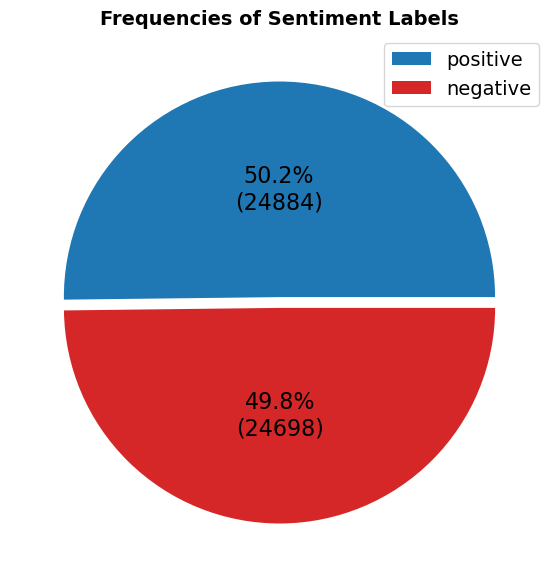

In [9]:
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Frequency of sentiments
freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]
labels = ['positive', 'negative']

# Create pie chart
fig, ax = plt.subplots(figsize=[11, 7])
plt.pie(
    x=data,
    autopct=lambda pct: func(pct, data),
    explode=[0.025] * 2,
    pctdistance=0.5,
    colors=[sns.color_palette()[0], 'tab:red'],
    textprops={'fontsize': 16}
)

# Title and legend
plt.title('Frequencies of Sentiment Labels', fontsize=14, fontweight='bold')
plt.legend(labels, loc="best", prop={'size': 14})

# Save and show the pie chart
plt.savefig("PieChart.png")
plt.show()


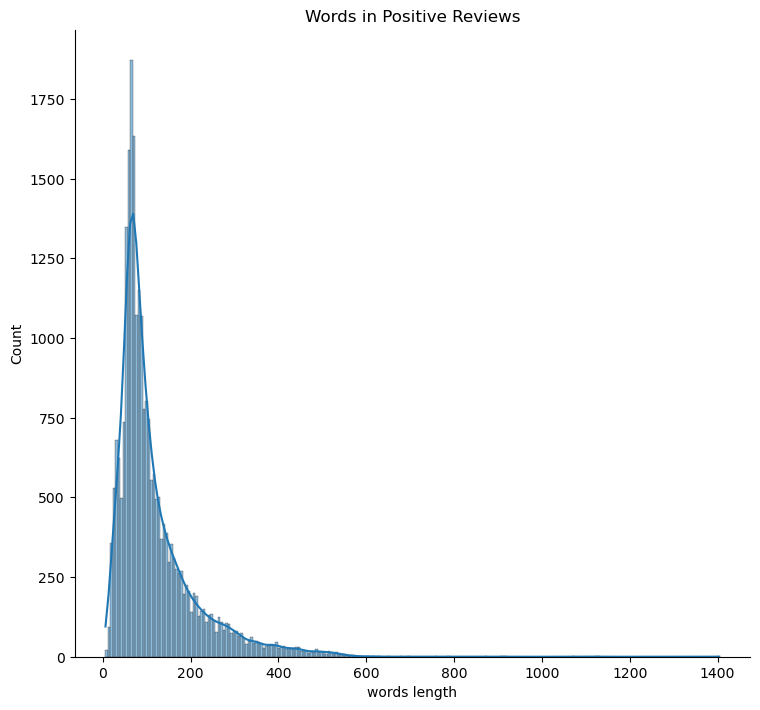

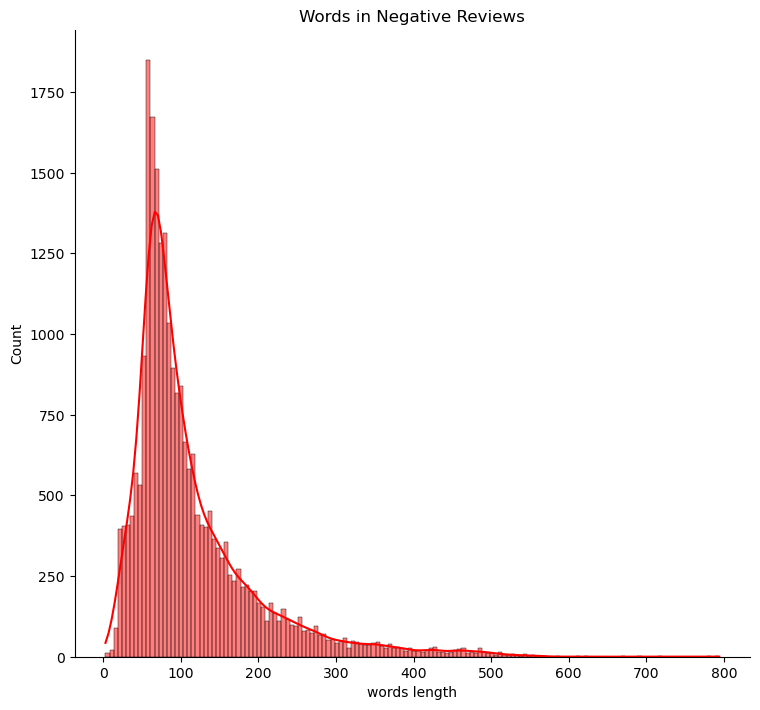

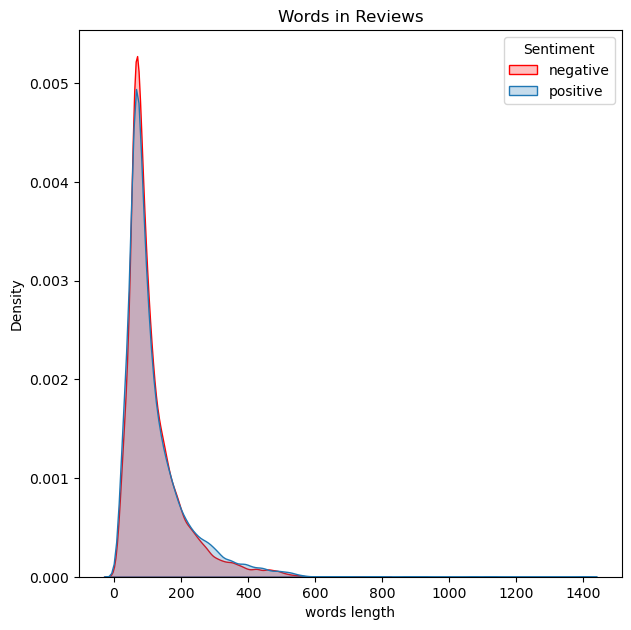

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate words length
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

# Histogram for positive reviews
hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x='words length',
    hue='sentiment',
    kde=True,
    height=7,
    aspect=1.1,
    legend=False
).set(title='Words in Positive Reviews')
plt.show()

# Histogram for negative reviews
hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x='words length',
    hue='sentiment',
    kde=True,
    height=7,
    aspect=1.1,
    legend=False,
    palette=['red']
).set(title='Words in Negative Reviews')
plt.show()

# Kernel density plot for words length
plt.figure(figsize=(7, 7.1))
kernel_distribution_number_words_plot = sns.kdeplot(
    data=df_temp,
    x='words length',
    hue='sentiment',
    fill=True,
    palette=[sns.color_palette()[0], 'red']
).set(title='Words in Reviews')
plt.legend(title='Sentiment', labels=['negative', 'positive'])
plt.show()


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [14]:
x_data = df['review']
# Step 4: Split the dataset into train and test sets
label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])

# Assuming 'x_data' is defined somewhere in your code, e.g., df['review']
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

# Step 5: Transform text into vectors using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

# Step 6: Train and evaluate Decision Tree model
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
dt_classifier.fit(x_train_encoded, y_train)
y_pred_dt = dt_classifier.predict(x_test_encoded)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {dt_accuracy:.2f}')

# Train and evaluate Random Forest model
rf_classifier = RandomForestClassifier(
    random_state=42
    ,
)
rf_classifier.fit(x_train_encoded, y_train)
y_pred_rf = rf_classifier.predict(x_test_encoded)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy:.2f}')


Decision Tree Accuracy: 0.72
Random Forest Accuracy: 0.84
